In [1]:
import tensorflow as tf
from tensorflow.keras import applications, callbacks
from data_loader import create_datasets
from model_builders import MODEL_BUILDERS
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
tf.random.set_seed(24520152)

PREPROCESSOR = {
    "EfficientNetB5": applications.efficientnet.preprocess_input,
    "DenseNet121": applications.densenet.preprocess_input,
    "ResNet50V2": applications.resnet_v2.preprocess_input,
    "MobileNetV2": applications.mobilenet_v2.preprocess_input,
}

In [3]:
BASE_DIR = os.path.dirname(os.getcwd())
TRAIN_DIR = os.path.join(BASE_DIR, "dataset", "train")
SAVE_DIR = os.path.join(BASE_DIR, "checkpoints")
HIS_DIR = os.path.join(BASE_DIR, "history")

In [4]:
BASE_DIR

'c:\\Users\\PC\\Desktop\\UIT\\TU_CHON_TU_DO\\CS406_XU_LY_ANH_VA_UNG_DUNG\\image-classification'

In [5]:
TRAIN_DIR

'c:\\Users\\PC\\Desktop\\UIT\\TU_CHON_TU_DO\\CS406_XU_LY_ANH_VA_UNG_DUNG\\image-classification\\dataset\\train'

In [6]:
SAVE_DIR

'c:\\Users\\PC\\Desktop\\UIT\\TU_CHON_TU_DO\\CS406_XU_LY_ANH_VA_UNG_DUNG\\image-classification\\checkpoints'

In [7]:
HIS_DIR

'c:\\Users\\PC\\Desktop\\UIT\\TU_CHON_TU_DO\\CS406_XU_LY_ANH_VA_UNG_DUNG\\image-classification\\history'

In [8]:
MODELS = [
    "EfficientNetB5",
    "DenseNet121",
    "ResNet50V2",
    "MobileNetV2",
]

In [9]:
BACKBONE = {
    "EfficientNetB5": "efficientnetb5",
    "DenseNet121": "densenet121",
    "ResNet50V2": "resnet50v2",
    "MobileNetV2": "mobilenetv2_1.00_224",
}

In [10]:
def fine_tune_and_save_model(model_name, train_dir, save_dir, his_dir, VAL_SPLIT=0.2, IMG_SIZE=(224, 224), BATCH_SIZE=32, FINE_TUNE_AT=-30, LEARNING_RATE=0.00001, EPOCHS=50):
    # Prepare preprocess function and datasets
    preprocess_fn = PREPROCESSOR[model_name] 
    train_ds, val_ds = create_datasets(train_dir=train_dir, preprocess_fn=preprocess_fn, VAL_SPLIT=VAL_SPLIT, IMG_SIZE=IMG_SIZE, BATCH_SIZE=BATCH_SIZE)
    
    # Load model
    model = tf.keras.models.load_model(os.path.join(save_dir, f"{model_name}_best.keras"))
    print(model.summary())

    backbone = model.get_layer(BACKBONE[model_name])
    backbone.trainable = True

    fine_tune_at = FINE_TUNE_AT
    for layer in backbone.layers[:fine_tune_at]:
        layer.trainable = False

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    # Set up callbacks
    checkpoint_path = os.path.join(save_dir, f"{model_name}_finetune.keras")

    callback_list = [
        callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            monitor="val_accuracy",
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
        ),
        callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience=5,
            verbose=1,
            restore_best_weights=True,
        ),
        callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.2,
            patience=5,
            verbose=1,
        )
    ]

    initial_epoch = len(pd.read_csv(os.path.join(his_dir, f"{model_name}_history.csv")))
    fine_tune_epochs = EPOCHS
    total_epochs = initial_epoch + fine_tune_epochs

    # Train model
    history = model.fit(
        train_ds,
        epochs=total_epochs,
        initial_epoch=initial_epoch,
        verbose=1,
        callbacks=callback_list,
        validation_data=val_ds,
    )

    return history

In [11]:
for model_name in MODELS:
    print(f"\nFine-tuning model: {model_name}")
    finetune_history = fine_tune_and_save_model(
        model_name=model_name,
        train_dir=TRAIN_DIR,
        save_dir=SAVE_DIR,
        his_dir=HIS_DIR,
    )
    pd.DataFrame(finetune_history.history).to_csv(os.path.join(HIS_DIR, f"{model_name}_finetune_history.csv"), index=False)


Fine-tuning model: EfficientNetB5
Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


Model: "EfficientNetB5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb5 (Functional)     │ (None, 7, 7, 2048)     │    28,513,527 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 6)              │        12,294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,550,411 (108.91 MB)

 Trainable params: 12,294 (48.02 KB)

 Non-trainable params: 28,513,527 (108.77 MB)

 Optimizer params: 24,590 (96.06 KB)

None
Epoch 16/65
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8827 - loss: 0.3221
Epoch 16: val_accuracy improved from None to 0.92908, saving model to c:\Users\PC\Desktop\UIT\TU_CHON_TU_DO\CS406_XU_LY_ANH_VA_UNG_DUNG\image-classification\checkpoints\EfficientNetB5_finetune.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 776s 2s/step - accuracy: 0.8936 - loss: 0.2919 - val_accuracy: 0.9291 - val_loss: 0.2058 - learning_rate: 1.0000e-05
Epoch 17/65
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8976 - loss: 0.2699
Epoch 17: val_accuracy improved from 0.92908 to 0.93122, saving model to c:\Users\PC\Desktop\UIT\TU_CHON_TU_DO\CS406_XU_LY_ANH_VA_UNG_DUNG\image-classification\checkpoints\EfficientNetB5_finetune.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 712s 2s/step - accuracy: 0.9040 - loss: 0.2572 - val_accuracy: 0.9312 - val_loss: 0.1991 - learning_rate: 1.0000e-05
Epoch 18/65
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9041 - loss: 0.2531
Epoch 18: val_accuracy did not improve from 

Model: "DenseNet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,055,956 (26.92 MB)

 Trainable params: 6,150 (24.02 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

 Optimizer params: 12,302 (48.06 KB)

None
Epoch 16/65
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8727 - loss: 0.3680
Epoch 16: val_accuracy improved from None to 0.91875, saving model to c:\Users\PC\Desktop\UIT\TU_CHON_TU_DO\CS406_XU_LY_ANH_VA_UNG_DUNG\image-classification\checkpoints\DenseNet121_finetune.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 494s 1s/step - accuracy: 0.8751 - loss: 0.3560 - val_accuracy: 0.9187 - val_loss: 0.2309 - learning_rate: 1.0000e-05
Epoch 17/65
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8784 - loss: 0.3491
Epoch 17: val_accuracy improved from 0.91875 to 0.92088, saving model to c:\Users\PC\Desktop\UIT\TU_CHON_TU_DO\CS406_XU_LY_ANH_VA_UNG_DUNG\image-classification\checkpoints\DenseNet121_finetune.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 437s 1s/step - accuracy: 0.8784 - loss: 0.3404 - val_accuracy: 0.9209 - val_loss: 0.2280 - learning_rate: 1.0000e-05
Epoch 18/65
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 993ms/step - accuracy: 0.8809 - loss: 0.3336
Epoch 18: val_accuracy improved from 0.92088 to

Model: "ResNet50V2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 6)              │        12,294 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,601,684 (90.03 MB)

 Trainable params: 12,294 (48.02 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

 Optimizer params: 24,590 (96.06 KB)

None
Epoch 14/63
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8450 - loss: 0.4379
Epoch 14: val_accuracy improved from None to 0.91839, saving model to c:\Users\PC\Desktop\UIT\TU_CHON_TU_DO\CS406_XU_LY_ANH_VA_UNG_DUNG\image-classification\checkpoints\ResNet50V2_finetune.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 484s 1s/step - accuracy: 0.8656 - loss: 0.3761 - val_accuracy: 0.9184 - val_loss: 0.2534 - learning_rate: 1.0000e-05
Epoch 15/63
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8900 - loss: 0.3054
Epoch 15: val_accuracy improved from 0.91839 to 0.91981, saving model to c:\Users\PC\Desktop\UIT\TU_CHON_TU_DO\CS406_XU_LY_ANH_VA_UNG_DUNG\image-classification\checkpoints\ResNet50V2_finetune.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 450s 1s/step - accuracy: 0.9004 - loss: 0.2809 - val_accuracy: 0.9198 - val_loss: 0.2427 - learning_rate: 1.0000e-05
Epoch 16/63
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9123 - loss: 0.2456
Epoch 16: val_accuracy improved from 0.91981 to 0.92

Model: "MobileNetV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,281,044 (8.70 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 15,374 (60.06 KB)

None
Epoch 17/66
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.8066 - loss: 0.5359
Epoch 17: val_accuracy improved from None to 0.90734, saving model to c:\Users\PC\Desktop\UIT\TU_CHON_TU_DO\CS406_XU_LY_ANH_VA_UNG_DUNG\image-classification\checkpoints\MobileNetV2_finetune.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 191s 505ms/step - accuracy: 0.8285 - loss: 0.4704 - val_accuracy: 0.9073 - val_loss: 0.2724 - learning_rate: 1.0000e-05
Epoch 18/66
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.8590 - loss: 0.3854
Epoch 18: val_accuracy improved from 0.90734 to 0.91019, saving model to c:\Users\PC\Desktop\UIT\TU_CHON_TU_DO\CS406_XU_LY_ANH_VA_UNG_DUNG\image-classification\checkpoints\MobileNetV2_finetune.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 144s 409ms/step - accuracy: 0.8678 - loss: 0.3618 - val_accuracy: 0.9102 - val_loss: 0.2621 - learning_rate: 1.0000e-05
Epoch 19/66
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.8745 - loss: 0.3494
Epoch 19: val_accuracy did not impr

In [12]:
histories = {}
for model_name in MODELS:
    file_path = os.path.join(HIS_DIR, f"{model_name}_history.csv")
    if os.path.exists(file_path):
        histories[model_name] = pd.read_csv(file_path)
    else:
        raise FileNotFoundError(f"History file not found for {model_name} at {file_path}")

histories

{'EfficientNetB5':     accuracy      loss  val_accuracy  val_loss  learning_rate
 0   0.848771  0.440595      0.918389  0.242843          0.001
 1   0.892323  0.291970      0.921953  0.223533          0.001
 2   0.900962  0.273178      0.920171  0.211076          0.001
 3   0.901496  0.264852      0.926942  0.205185          0.001
 4   0.906484  0.249322      0.930506  0.196985          0.001
 5   0.906038  0.246082      0.930862  0.198218          0.001
 6   0.907909  0.243498      0.926586  0.200141          0.001
 7   0.908799  0.236547      0.928368  0.195256          0.001
 8   0.913698  0.228372      0.930862  0.196782          0.001
 9   0.911115  0.229312      0.933713  0.192649          0.001
 10  0.913253  0.228022      0.933713  0.194949          0.001
 11  0.916192  0.225035      0.930150  0.189307          0.001
 12  0.915924  0.220834      0.929793  0.196350          0.001
 13  0.914054  0.222180      0.930862  0.197673          0.001
 14  0.915034  0.222746      0.930150

In [13]:
finetune_histories = {}
for model_name in MODELS:
    file_path = os.path.join(HIS_DIR, f"{model_name}_finetune_history.csv")
    if os.path.exists(file_path):
        finetune_histories[model_name] = pd.read_csv(file_path)
    else:
        raise FileNotFoundError(f"History file not found for {model_name} at {file_path}")

finetune_histories

{'EfficientNetB5':     accuracy      loss  val_accuracy  val_loss  learning_rate
 0   0.893570  0.291852      0.929081  0.205839        0.00001
 1   0.903990  0.257190      0.931219  0.199115        0.00001
 2   0.908443  0.243423      0.930150  0.194335        0.00001
 3   0.914678  0.228038      0.932288  0.189721        0.00001
 4   0.921892  0.217613      0.935139  0.185515        0.00001
 5   0.922515  0.209637      0.935495  0.182721        0.00001
 6   0.926167  0.199956      0.935139  0.180819        0.00001
 7   0.929373  0.196636      0.935495  0.179521        0.00001
 8   0.929996  0.194616      0.937634  0.176712        0.00001
 9   0.932312  0.189625      0.936565  0.176757        0.00001
 10  0.937923  0.171738      0.938703  0.175262        0.00001
 11  0.938814  0.170588      0.938703  0.175038        0.00001
 12  0.938368  0.166136      0.942267  0.174257        0.00001
 13  0.941842  0.158275      0.940128  0.173082        0.00001
 14  0.942376  0.155808      0.937634

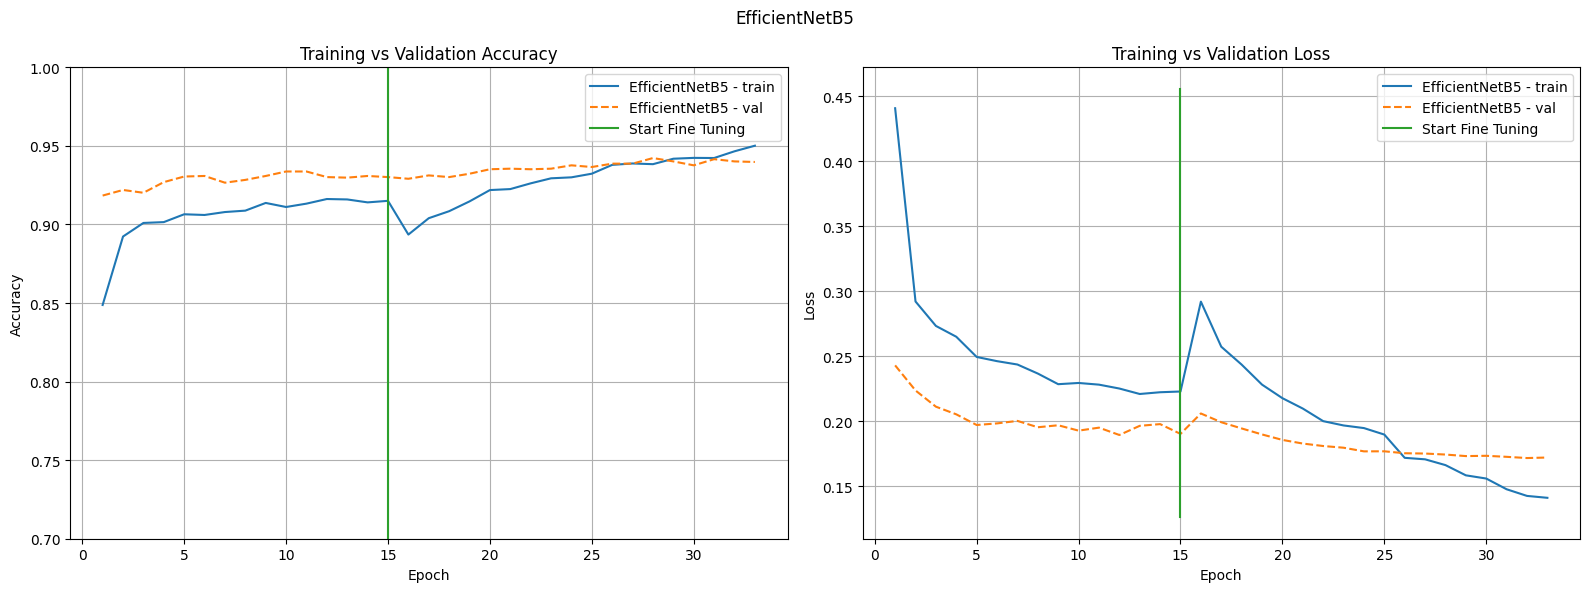

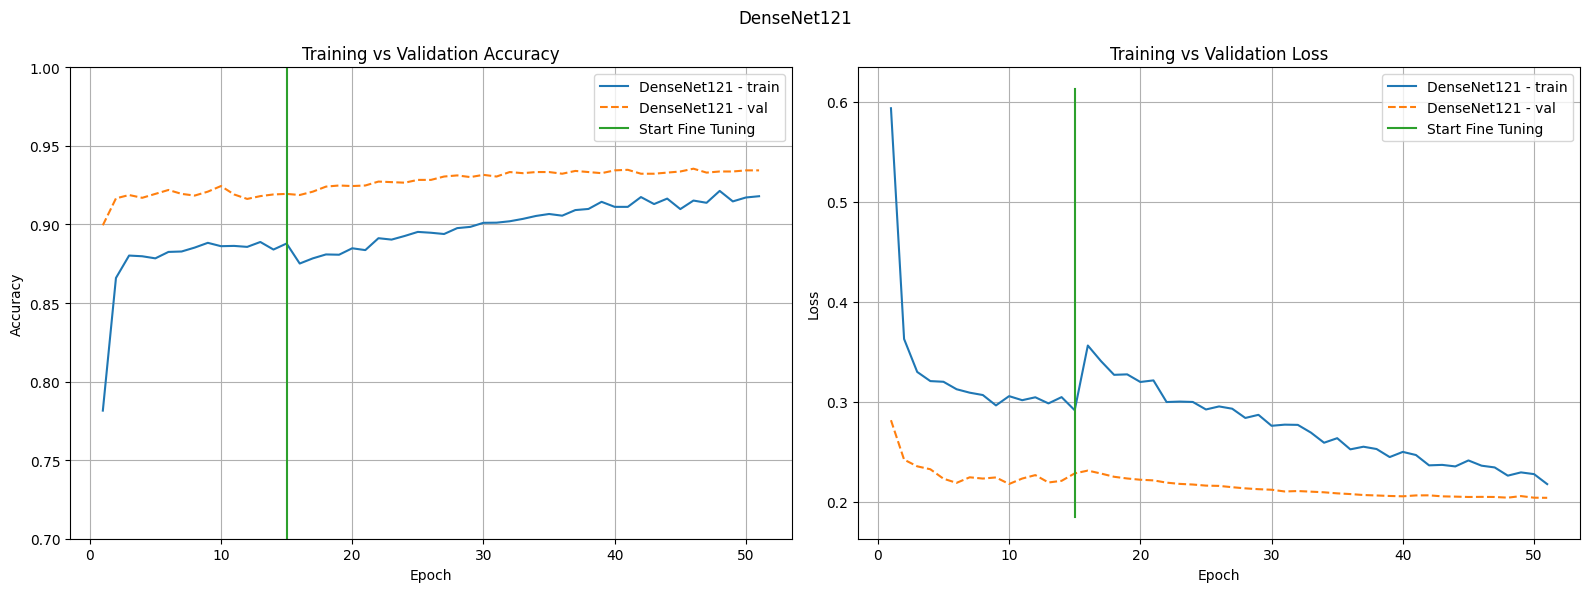

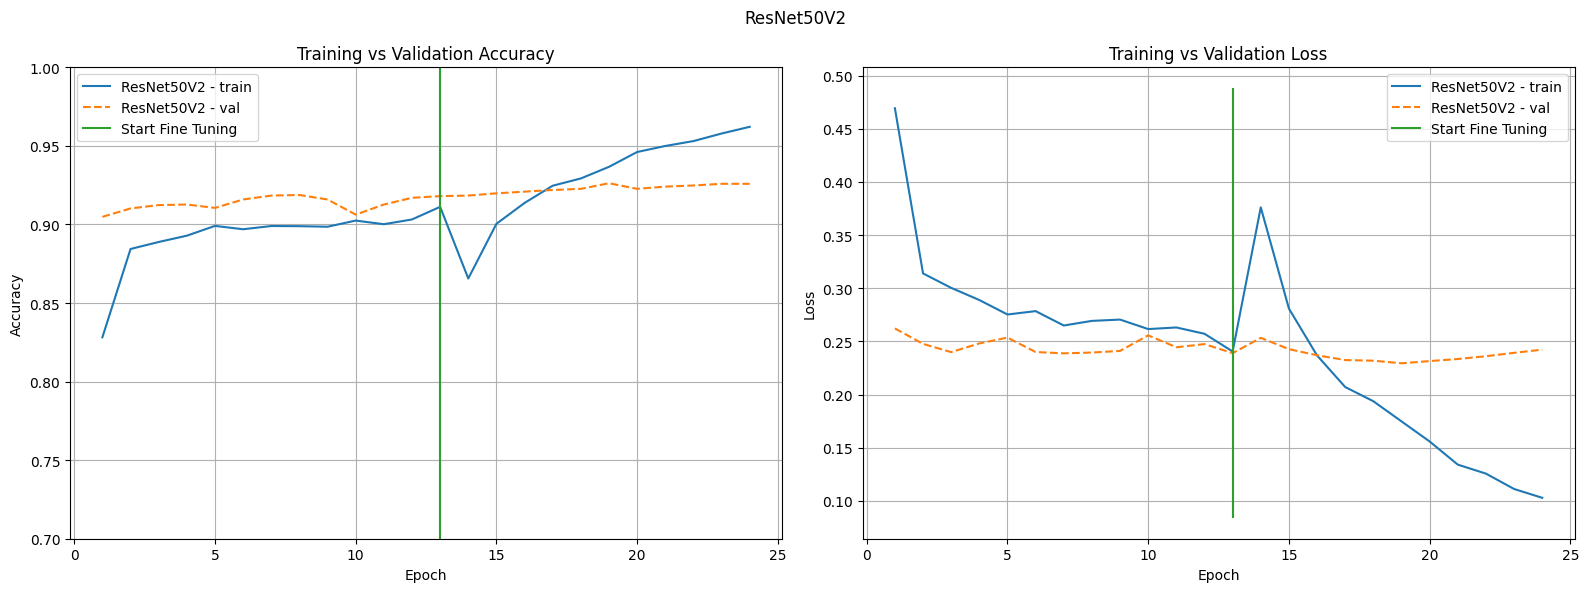

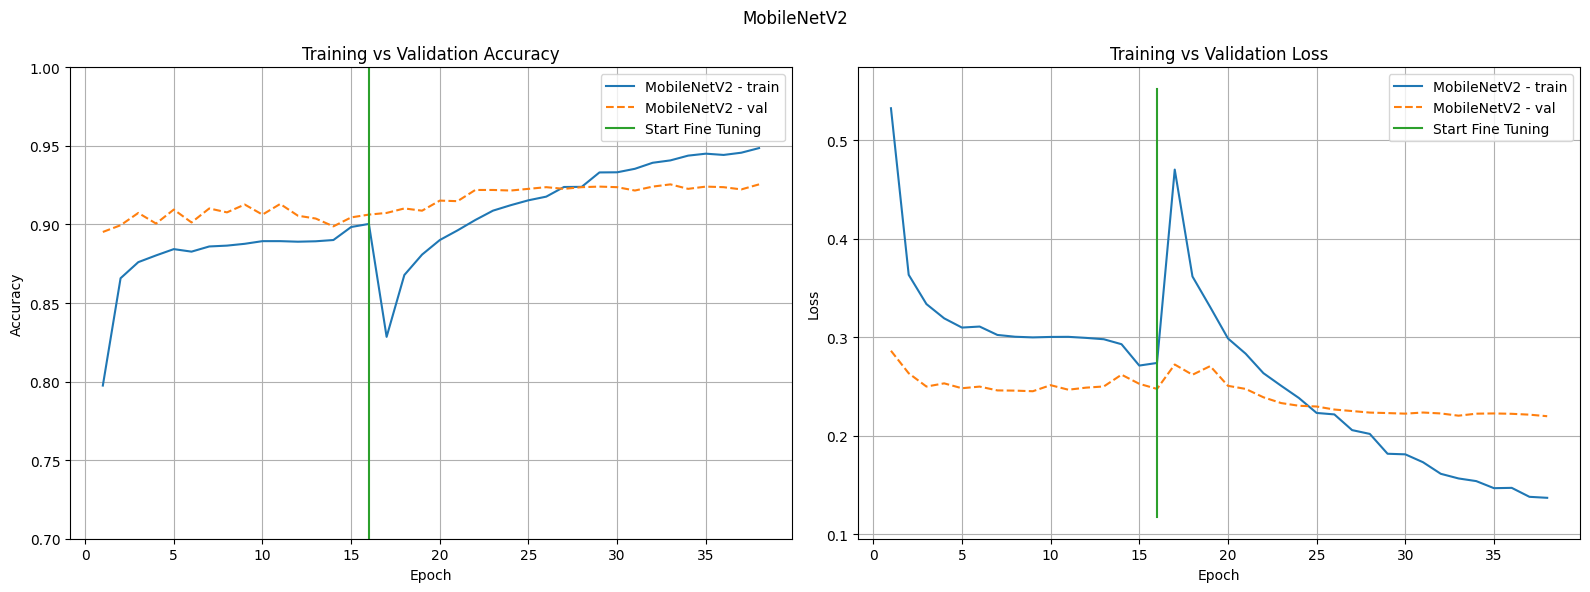

In [14]:
for (name, hist), (finetune_name, finetune_hist) in zip(histories.items(), finetune_histories.items()):
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f"{name}")

    acc = hist["accuracy"]
    val_acc = hist["val_accuracy"]
    finetune_acc = finetune_hist["accuracy"]
    finetune_val_acc = finetune_hist["val_accuracy"]
    acc_df = pd.concat([acc, finetune_acc], ignore_index=True)
    val_acc_df = pd.concat([val_acc, finetune_val_acc], ignore_index=True)
    
    axs[0].plot(range(1, len(acc_df) + 1), acc_df, label=f"{name} - train")
    axs[0].plot(range(1, len(val_acc_df) + 1), val_acc_df, linestyle="--", label=f"{name} - val")
    axs[0].set_ylim([0.7, 1])
    axs[0].plot([len(acc), len(acc)], plt.ylim(), label="Start Fine Tuning")
    axs[0].set_title("Training vs Validation Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()
    axs[0].grid()

    loss = hist["loss"]
    val_loss = hist["val_loss"]
    finetune_loss = finetune_hist["loss"]
    finetune_val_loss = finetune_hist["val_loss"]
    loss_df = pd.concat([loss, finetune_loss], ignore_index=True)
    val_loss_df = pd.concat([val_loss, finetune_val_loss], ignore_index=True)

    axs[1].plot(range(1, len(loss_df) + 1), loss_df, label=f"{name} - train")
    axs[1].plot(range(1, len(val_loss_df) + 1), val_loss_df, linestyle="--", label=f"{name} - val")
    axs[1].plot([len(acc), len(acc)], plt.ylim(), label="Start Fine Tuning")
    axs[1].set_title("Training vs Validation Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend()
    axs[1].grid()

    fig.tight_layout()

In [15]:
summary_finetune_data = []

for finetune_name, finetune_hist in finetune_histories.items():
    best_epoch = finetune_hist["val_accuracy"].idxmax() + 1
    best_val_acc = finetune_hist["val_accuracy"].max()
    best_val_loss = finetune_hist["val_loss"][best_epoch - 1]
    final_train_acc = finetune_hist["accuracy"].iloc[-1]
    final_val_acc = finetune_hist["val_accuracy"].iloc[-1]

    summary_finetune_data.append({
        "Model": name,
        "Best Epoch": best_epoch,
        "Best Val Accuracy": best_val_acc,
        "Best Val Loss": best_val_loss,
        "Final Train Accuracy": final_train_acc,
        "Final Val Accuracy": final_val_acc,
    })

summary_finetune_df = pd.DataFrame(summary_finetune_data)
summary_finetune_df = summary_finetune_df.sort_values("Best Val Accuracy", ascending=False).reset_index(drop=True)
summary_finetune_df.style.background_gradient(cmap="Blues", subset=["Best Val Accuracy"])

,Model,Best Epoch,Best Val Accuracy,Best Val Loss,Final Train Accuracy,Final Val Accuracy
0,MobileNetV2,13,0.942267,0.174257,0.950125,0.939772
1,MobileNetV2,31,0.935495,0.204641,0.917973,0.934426
2,MobileNetV2,6,0.926230,0.229467,0.962148,0.925873
3,MobileNetV2,17,0.925517,0.220499,0.948611,0.925517
